In [298]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import pickle
import os

warnings.filterwarnings('ignore')

## Loading Dataset

In [300]:
db = pd.read_csv("./datasets/mockData.csv")

In [301]:
db.head()

,Unnamed: 0,Time,Unix Time,Trans_Id,Name,Acc Num,Merchant Name,Merchant Acc Name,Amount,Category,Lat,Long,Is_Safe
0,0,2024-01-05 08:15:00,1641383700,TID123459,Bob,23456789012,EntertainmentCo,EC_Account,21.948058,entertainment,34.0522,-118.2437,0
1,1,2024-01-05 12:30:00,1641401400,TID123463,Bob,23456789012,HealthBuddy,HB_Account,355.119064,health_fitness,34.0522,-118.2437,1
2,2,2024-01-05 15:45:00,1641411900,TID123512,Bob,23456789012,HomeHeaven,HH_Account,6.025573,home,34.0522,-118.2437,0
3,3,2024-01-05 19:00:00,1641422400,TID123476,Bob,23456789012,TravelGalaxy,TG_Account,1972.817327,travel,34.0522,-118.2437,1
4,4,2024-01-05 22:15:00,1641432900,TID123456,Bob,23456789012,PetParadise,PP_Account,366.007992,kids_pets,34.0522,-118.2437,0


In [302]:
features = ["cc_num","category","amt","gender","city","state","lat","long","is_fraud"]

db = db[features]

KeyError: "None of [Index(['cc_num', 'category', 'amt', 'gender', 'city', 'state', 'lat', 'long',\n       'is_fraud'],\n      dtype='object')] are in the [columns]"

In [ ]:
fraud_db = db[db.is_fraud==1]
legit_db = db[db.is_fraud==0]

## Feature Engineering

In [ ]:
category_name_map = {"misc_net":"misc","grocery_pos":"grocery","misc_pos":"misc","grocery_net":"grocery","shopping_net":"shopping","shopping_pos":"shopping"}

legit_db.category = legit_db.category.apply(lambda x: category_name_map[x] if x in category_name_map else x)

In [ ]:
categories = legit_db["category"].unique()

In [ ]:
legit_db["amt"] = np.log(legit_db["amt"]) # To normalize skewed data

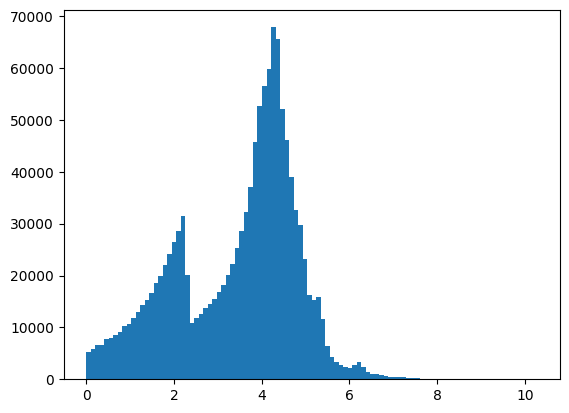

In [ ]:
temp = plt.hist(legit_db["amt"],bins=100)

## EDA

### Spending Patterns by Category

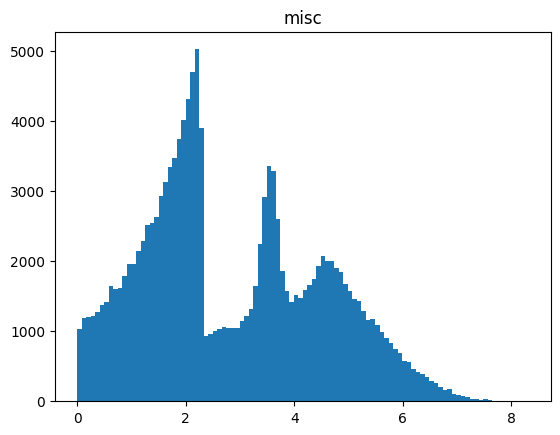

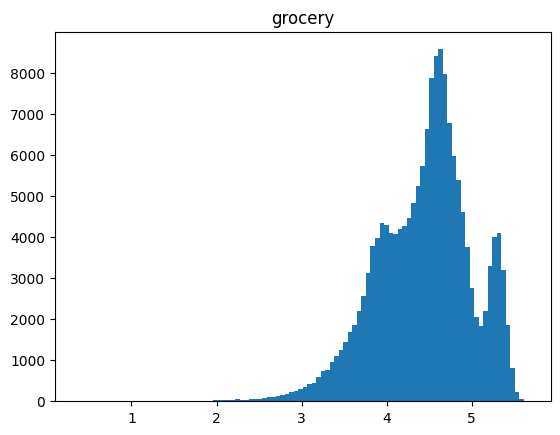

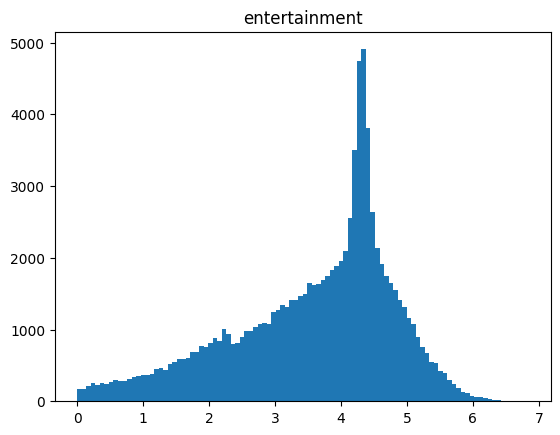

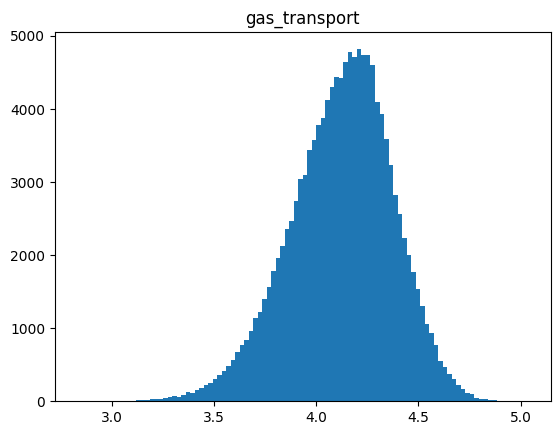

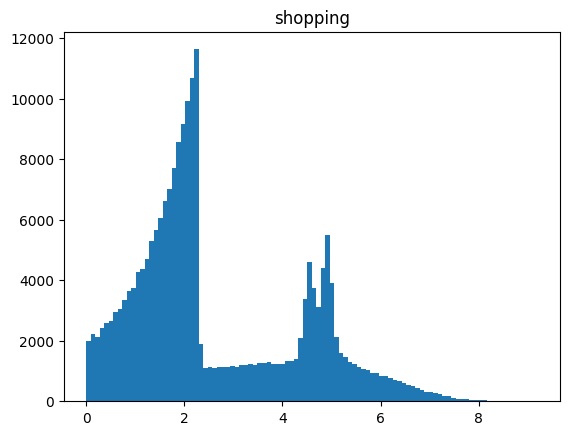

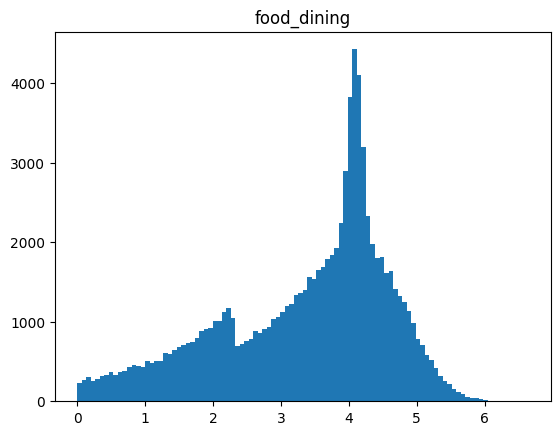

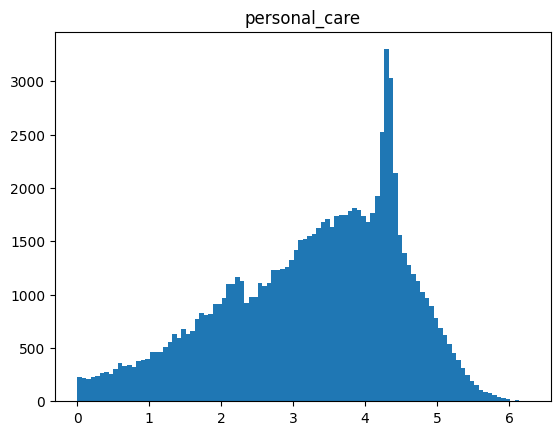

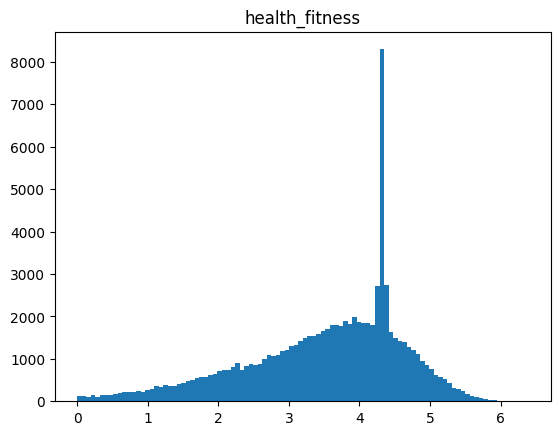

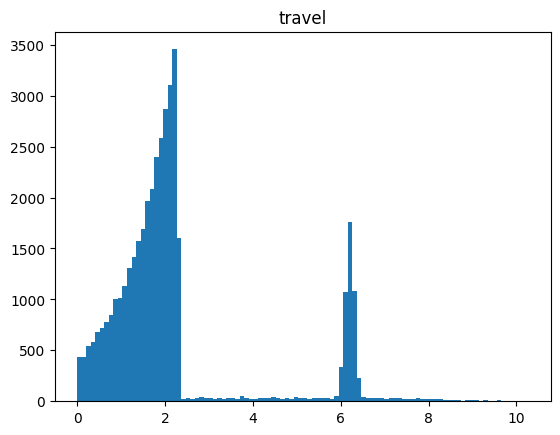

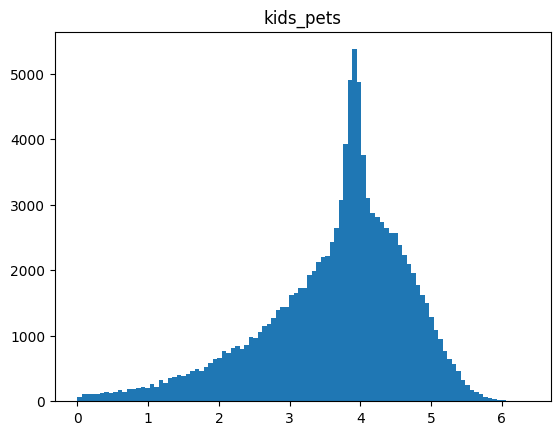

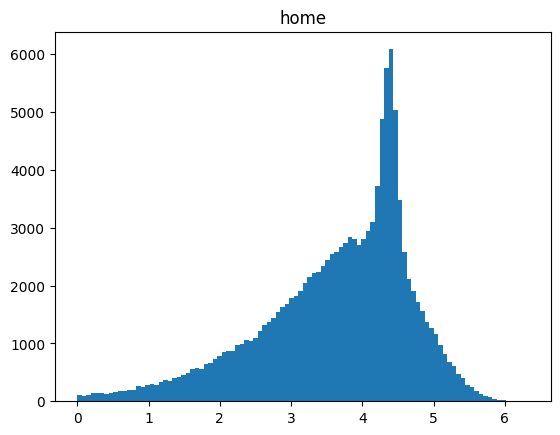

In [ ]:
for i in range(len(categories)):
    plt.title(categories[i])
    plt.hist(legit_db[legit_db["category"] == categories[i]]["amt"],bins=100)
    plt.show()

### Clustering Total Expenditure for Customer Segmentation

In [ ]:
from sklearn.cluster import KMeans

inertias = []

for i in range(1,10):
    print(f"{i} Cluster(s)")
    model = KMeans(n_clusters=i)
    model.fit(legit_db["amt"].values.reshape(-1,1))
    inertias += [model.inertia_]


1 Cluster(s)
2 Cluster(s)
3 Cluster(s)
4 Cluster(s)
5 Cluster(s)
6 Cluster(s)
7 Cluster(s)
8 Cluster(s)
9 Cluster(s)


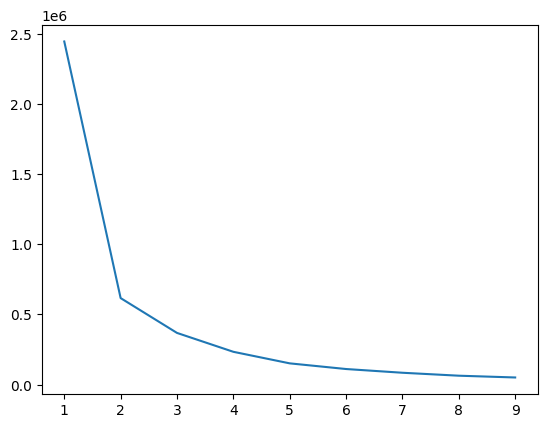

In [ ]:
plt.plot(np.arange(1,10),inertias)

In [ ]:

### PICKLE !!!!!!

from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=2)
legit_db["clusters"] = model.fit_predict(legit_db["amt"].values.reshape(-1,1))

with open("./models/amount_clusters.pkl","wb") as f:
    pickle.dump(model, f)

In [ ]:
order = np.argsort(model.means_,axis=0).flatten()

[[4.24599802]
 [1.75681042]]


array([1, 0])

## Segmenting Customers into High Spenders & Low Spenders

<Axes: xlabel='clusters', ylabel='amt'>

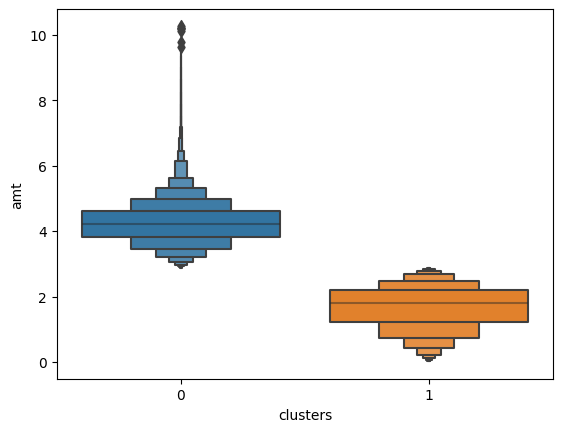

In [ ]:
sns.boxenplot(y=legit_db["amt"],x=legit_db["clusters"])

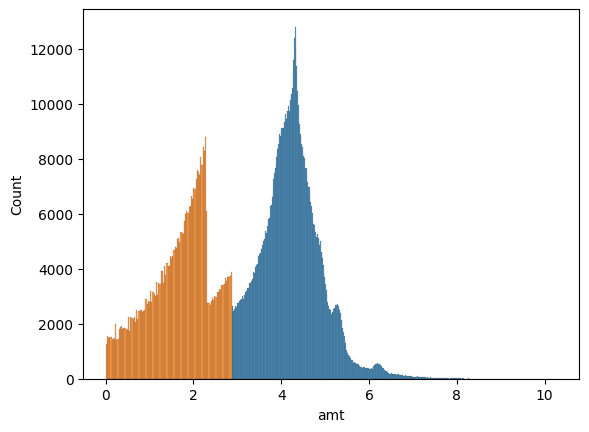

In [ ]:
for i in range(2):
    sns.histplot(legit_db[legit_db["clusters"] == i]["amt"])

In [ ]:
low_spend = legit_db[legit_db["clusters"] == 1]
high_spend = legit_db[legit_db["clusters"] == 0]

In [ ]:

# PICKLE !!!!!!!

from sklearn.ensemble import IsolationForest

for i in range(len(order)):

    model = IsolationForest(n_estimators=500,contamination=0.02)
    model.fit(legit_db[legit_db["clusters"] == i].amt.values.reshape(-1,1))

    with open(f"./models/amount_cluster_segment{order[i]}isolationForest.pkl","wb") as f:
        pickle.dump(model, f)

In [ ]:
with open("./models/amount_cluster_segment0isolationForest.pkl","rb") as f:
    model = pickle.load(f)

i = 3
model.score_samples([[i]]),model.predict([[i]])

(array([-0.65860701]), array([-1]))

## Clustering Spending Patterns within Each Category

[[3.7046582]
 [1.5566512]
 [5.2114682]]
[1 0 2]


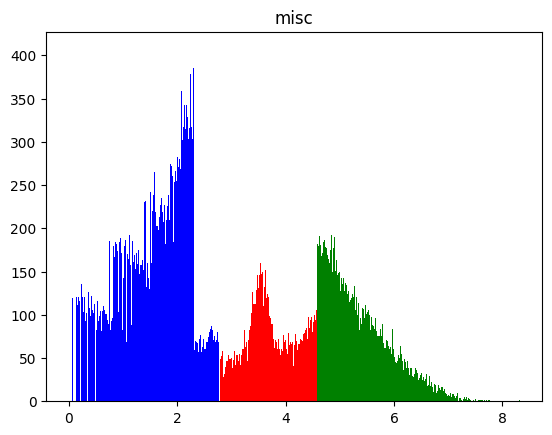

[[4.48888301]
 [4.89139557]
 [3.65521529]]
[2 0 1]


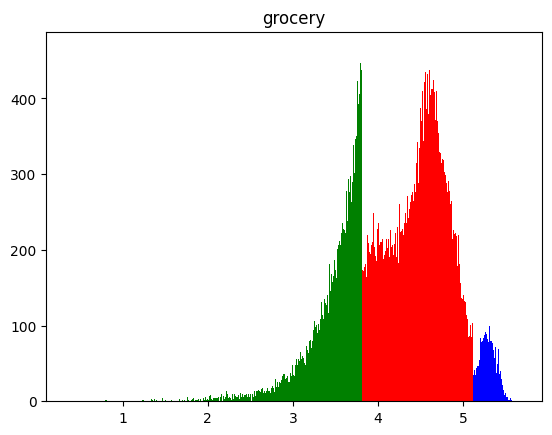

[[4.93968358]
 [1.63624711]]
[1 0]


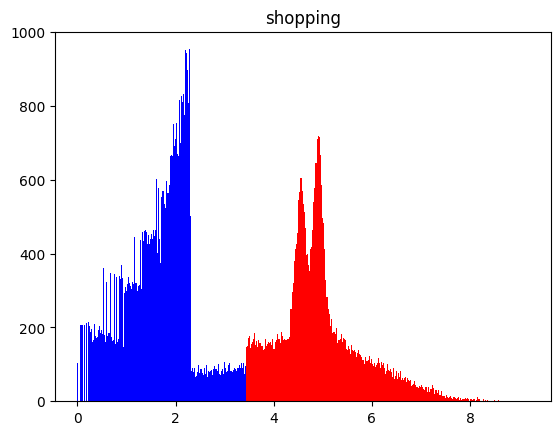

[[3.99786396]
 [1.68103188]]
[1 0]


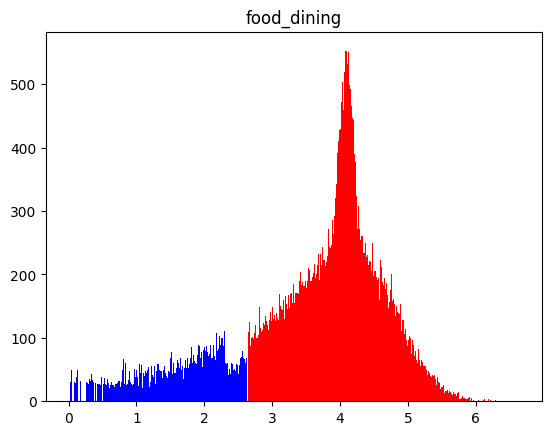

[[1.57256666]
 [6.24659713]]
[0 1]


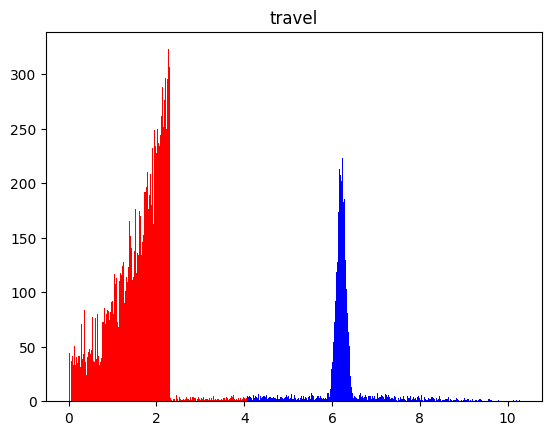

In [ ]:
mixture_categories = ['misc','grocery','shopping','food_dining','travel']
mixture_components = [3,3,2,2,2]
colors = ['red','blue','green','orange','cyan']

# PICKLE !!!

for i in range(len(mixture_categories)):

    hm = legit_db[legit_db["category"] == mixture_categories[i]]

    model1 = GaussianMixture(n_components=mixture_components[i],covariance_type="tied")
    hm["cluster"] = model1.fit_predict(hm.amt.values.reshape(-1,1))
    
    if f"amount_by_{mixture_categories[i]}" not in os.listdir("./models"):
        os.mkdir(f"./models/amount_by_{mixture_categories[i]}")

    with open(f"./models/amount_by_{mixture_categories[i]}/clusters.pkl","wb") as f:
        pickle.dump(model, f)


    print(model1.means_)
    order = np.argsort(model1.means_,axis=0).flatten()
    print(order)

    for j in range(mixture_components[i]):

        model2 = IsolationForest(n_estimators=500,contamination=0.01)
        model2.fit(hm[hm["cluster"] == j]["amt"].values.reshape(-1,1))

        with open(f"./models/amount_by_{mixture_categories[i]}/segment_{order[j]}_iForest.pkl","wb") as f:
            pickle.dump(model2,f)

        plt.title(mixture_categories[i])
        plt.hist(hm[hm["cluster"] == j]["amt"],color=colors[j],bins=500)
    
    plt.show()


In [ ]:
remaining_categories = list(set(categories) - set(mixture_categories))

for i in range(len(remaining_categories)):

    hm = legit_db[legit_db["category"] == remaining_categories[i]]

    model1 = IsolationForest(n_estimators=5,contamination=0.01)
    hm["cluster"] = model1.fit_predict(hm.amt.values.reshape(-1,1))
    
    if f"amount_by_{remaining_categories[i]}" not in os.listdir("./models"):
        os.mkdir(f"./models/amount_by_{remaining_categories[i]}")

    with open(f"./models/amount_by_{remaining_categories[i]}/iForest.pkl","wb") as f:
        pickle.dump(model, f)